### Mark Hoogendoorn and Burkhardt Funk (2017)              
Machine Learning for the Quantified Self               
Springer, 
Chapter 7    

In [19]:
from util.VisualizeDataset import VisualizeDataset
from Chapter7.PrepareDatasetForLearning import PrepareDatasetForLearning
from Chapter7.LearningAlgorithms import ClassificationAlgorithms
from Chapter7.LearningAlgorithms import RegressionAlgorithms
from Chapter7.Evaluation import ClassificationEvaluation
from Chapter7.Evaluation import RegressionEvaluation
from Chapter7.FeatureSelection import FeatureSelectionClassification
from Chapter7.FeatureSelection import FeatureSelectionRegression
import copy
import pandas as pd
from util import util
import matplotlib.pyplot as plot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from util import ClassificationReport
import os

In [20]:
DataViz = VisualizeDataset()

# Read the result from the previous chapter, and make sure the index is of the type datetime.
dataset_path = 'intermediate_datafiles/'

export_tree_path = 'Example_graphs/Chapter7/'

try:
    dataset = pd.read_csv(dataset_path + 'chapter5_result.csv', index_col=0)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

if not os.path.exists(export_tree_path):
    os.makedirs(export_tree_path)

dataset.index = pd.to_datetime(dataset.index, format='%Y-%m-%d %H:%M:%S.%f'[:-3])

In [21]:
del dataset['category']
del dataset['set']

In [22]:
individual_data = dataset[dataset['participant'] == dataset['participant'].unique()[1]]
remaining_data = dataset[dataset['participant'] != dataset['participant'].unique()[1]]

In [23]:
del individual_data['participant']
del remaining_data['participant']

In [24]:
# Let us consider our first task, namely the prediction of the label. We consider this as a non-temporal task.

# We create a single column with the categorical attribute representing our class. Furthermore, we use 70% of our data
# for training and the remaining 30% as an independent test set. We select the sets based on stratified sampling. We remove
# cases where we do not know the label.

prepare = PrepareDatasetForLearning()

train_X, test_X, train_y, test_y = prepare.split_single_dataset_classification(individual_data, ['label'], 'like', 0.7, filter=True, temporal=False)

print 'Training set length is: ', len(train_X.index)
print 'Test set length is: ', len(test_X.index)

# Select subsets of the features that we will consider:

basic_features = ['x_gyr','y_gyr','z_gyr', 'x_acc','y_acc','z_acc']
pca_features = ['pca_1','pca_2', 'pca_3','pca_4']
time_features = [name for name in dataset.columns if '_temp_' in name]
freq_features = [name for name in dataset.columns if (('_freq' in name) or ('_pse' in name))]
print '#basic features: ', len(basic_features)
print '#PCA features: ', len(pca_features)
print '#time features: ', len(time_features)
print '#frequency features: ', len(freq_features)
cluster_features = ['cluster']
print '#cluster features: ', len(cluster_features)
features_after_chapter_3 = list(set().union(basic_features, pca_features))
features_after_chapter_4 = list(set().union(basic_features, pca_features, time_features, freq_features))
features_after_chapter_5 = list(set().union(basic_features, pca_features, time_features, freq_features, cluster_features))

Chapter7\PrepareDatasetForLearning.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataset['class'] = self.default_label
C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Training set length is:  1570
Test set length is:  674
#basic features:  6
#PCA features:  4
#time features:  12
#frequency features:  0
#cluster features:  1


In [25]:
learner = ClassificationAlgorithms()
eval = ClassificationEvaluation()

In [26]:
class_train_y, class_test_y, class_train_prob_y, class_test_prob_y, model = learner.random_forest(train_X[list(train_X)], train_y, test_X[list(train_X)],
                                                                                           gridsearch=True, print_model_details=True)

{'n_estimators': 50, 'criterion': 'entropy', 'min_samples_leaf': 2}
Feature importance random forest:
pca_1  &  0.193676450832
cluster  &  0.126847955553
gyr_z_temp_std_ws_4  &  0.0905189623265
acc_z_temp_mean_ws_4  &  0.0827105551497
acc_x_temp_mean_ws_4  &  0.0776609155677
acc_y_temp_mean_ws_4  &  0.0766433813109
pca_2  &  0.0718287487941
acc_y  &  0.0705306122085
acc_z  &  0.0586133644213
acc_x  &  0.0337655967005
acc_x_temp_std_ws_4  &  0.0303343730973
gyr_x_temp_std_ws_4  &  0.0227181159059
acc_y_temp_std_ws_4  &  0.0164735047906
acc_z_temp_std_ws_4  &  0.00991718426491
gyr_z  &  0.00720534424255
pca_4  &  0.006944278252
gyr_z_temp_mean_ws_4  &  0.0055318129247
pca_3  &  0.00386574130169
gyr_x_temp_mean_ws_4  &  0.00371686754907
gyr_y_temp_mean_ws_4  &  0.00323666117692
gyr_x  &  0.00255292444359
gyr_y  &  0.00240359668847
gyr_y_temp_std_ws_4  &  0.00230305249844


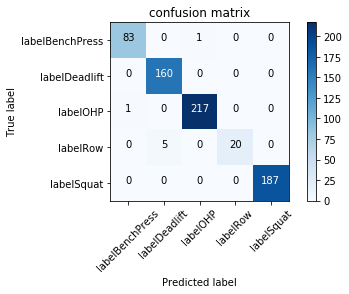

In [27]:
test_cm = eval.confusion_matrix(test_y, class_test_y, class_train_prob_y.columns)
DataViz.plot_confusion_matrix(test_cm, class_train_prob_y.columns, normalize=False)

In [28]:
accuracy_score(test_y, class_test_y)

0.98961424332344217

### Prepare medium weight data for classification

In [29]:
m_train_X, m_test_X, m_train_y, m_test_y = prepare.split_single_dataset_classification(remaining_data, ['label'], 'like', 0.05, filter=True, temporal=False)

In [30]:
pred_prob_training_y = model.predict_proba(m_train_X)
pred_prob_test_y = model.predict_proba(m_test_X)
pred_training_y = model.predict(m_train_X)
pred_test_y = model.predict(m_test_X)
frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=model.classes_)
frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=model.classes_)

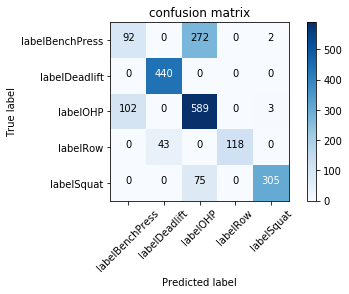

In [31]:
test_cm = eval.confusion_matrix(m_test_y, pred_test_y, frame_prob_training_y.columns)
DataViz.plot_confusion_matrix(test_cm, frame_prob_training_y.columns, normalize=False)

In [32]:
accuracy_score(m_test_y, pred_test_y)

0.75649191572758456